In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from datetime import datetime
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

# Fetch the stock data
company_data = {}

for stock in tech_list:
    company_data[stock] = yf.download(stock, start=start, end=end,actions=False)

# Add company name to each DataFrame and concatenate into a single DataFrame
company_list = [company_data[stock] for stock in tech_list]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for df, name in zip(company_list, company_name):
    df["company_name"] = name

df = pd.concat(company_list, axis=0)
print(df.tail(10))


yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-07-26  180.389999  183.190002  180.240005  182.500000  182.500000   
2024-07-29  183.839996  184.750000  182.380005  183.199997  183.199997   
2024-07-30  184.720001  185.860001  179.380005  181.710007  181.710007   
2024-07-31  185.050003  187.940002  184.460007  186.979996  186.979996   
2024-08-01  189.289993  190.600006  181.869995  184.070007  184.070007   
2024-08-02  166.750000  168.770004  160.550003  167.899994  167.899994   
2024-08-05  154.210007  162.960007  151.610001  161.020004  161.020004   
2024-08-06  161.710007  165.080002  158.539993  161.929993  161.929993   
2024-08-07  166.550003  167.580002  161.429993  162.770004  162.770004   
2024-08-08  165.169998  166.690002  162.550003  165.800003  165.800003   

               Volume company_name  
Date                                
2024-07-26   29506000       AMAZON  


In [2]:
# Describe the dataset statistically 
print(company_data['AAPL'].describe())

             Open        High         Low       Close   Adj Close  \
count  252.000000  252.000000  252.000000  252.000000  252.000000   
mean   187.474047  189.216627  185.868651  187.605516  187.240827   
std     16.263194   16.548456   15.838809   16.212961   16.359961   
min    165.350006  166.399994  164.080002  165.000000  164.776505   
25%    175.277496  177.052502  173.700005  175.370007  174.801842   
50%    183.980003  185.565002  182.334999  184.309998  183.908051   
75%    193.615002  194.730000  192.119999  193.239994  192.951744   
max    236.479996  237.229996  233.089996  234.820007  234.820007   

             Volume  
count  2.520000e+02  
mean   6.060901e+07  
std    2.469198e+07  
min    2.404830e+07  
25%    4.727445e+07  
50%    5.422255e+07  
75%    6.604168e+07  
max    2.464214e+08  


In [3]:
# Describe concisely the features,
# including the number of non-null values and data types
print(company_data['AAPL'].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2023-08-09 to 2024-08-08
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          252 non-null    float64
 1   High          252 non-null    float64
 2   Low           252 non-null    float64
 3   Close         252 non-null    float64
 4   Adj Close     252 non-null    float64
 5   Volume        252 non-null    int64  
 6   company_name  252 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.8+ KB
None


In [4]:
# Displaying rows and columns for the complete dataset
print("Dimensions of the Data:", df.shape)

Dimensions of the Data: (1008, 7)


In [5]:
# Displaying rows and columns for Apple
print("Dimensions of the Data:", company_data['AAPL'].shape)

Dimensions of the Data: (252, 7)


In [6]:
# Displaying rows and columns for Google
print(company_data['GOOG'].info())

# Describe concisely the features,
# including the number of non-null values and data types for Google 
print("Dimensions of the Data:", company_data['GOOG'].shape)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2023-08-09 to 2024-08-08
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          252 non-null    float64
 1   High          252 non-null    float64
 2   Low           252 non-null    float64
 3   Close         252 non-null    float64
 4   Adj Close     252 non-null    float64
 5   Volume        252 non-null    int64  
 6   company_name  252 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.8+ KB
None
Dimensions of the Data: (252, 7)


In [7]:
# Data Cleaning 
# Handling Missing Values 

# Checking and printing for Missing Values (NaN) in the datasets
print("Are there any missing points in the dataset?:", df.isnull().values.any(), "\n")

Are there any missing points in the dataset?: False 



In [8]:
# Handling Duplicate Values:
# Checking and printing for duplicated rows in the DataFrame
print("Number of Duplicated Rows:", df.duplicated().sum(), "\n")

Number of Duplicated Rows: 0 



In [9]:
# No need to remove duplicated and recheck 
# for dimensions because there are no duplicate

In [10]:
from sklearn.model_selection import train_test_split
data = company_data['AAPL']
#data = df 
# Prepare features and target
data['Target'] = data['Close'].shift(-1)  # Predict next day's price
data = data.dropna()
X = data[['Close']]
y = data['Target']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Verify the sizes
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 150
Validation set size: 50
Test set size: 51


<Axes: >

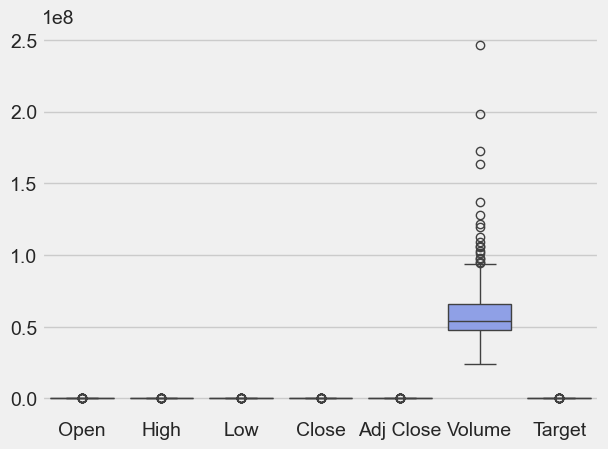

In [11]:
import seaborn as sns
sns.boxplot(data)

In [12]:
from scipy import stats

# Example DataFrame
data = df

# Ensure the data is numeric
numeric_data = data.select_dtypes(include=[np.number])

# Calculate z-scores
z_scores = stats.zscore(numeric_data)

# Identify outliers
outliers = (np.abs(z_scores) > 3)
            
# Print outliers
print("Outlier rows (True indicates an outlier):")
print(outliers)

Outlier rows (True indicates an outlier):
             Open   High    Low  Close  Adj Close  Volume
Date                                                     
2023-08-09  False  False  False  False      False   False
2023-08-10  False  False  False  False      False   False
2023-08-11  False  False  False  False      False   False
2023-08-14  False  False  False  False      False   False
2023-08-15  False  False  False  False      False   False
...           ...    ...    ...    ...        ...     ...
2024-08-02  False  False  False  False      False    True
2024-08-05  False  False  False  False      False   False
2024-08-06  False  False  False  False      False   False
2024-08-07  False  False  False  False      False   False
2024-08-08  False  False  False  False      False   False

[1008 rows x 6 columns]


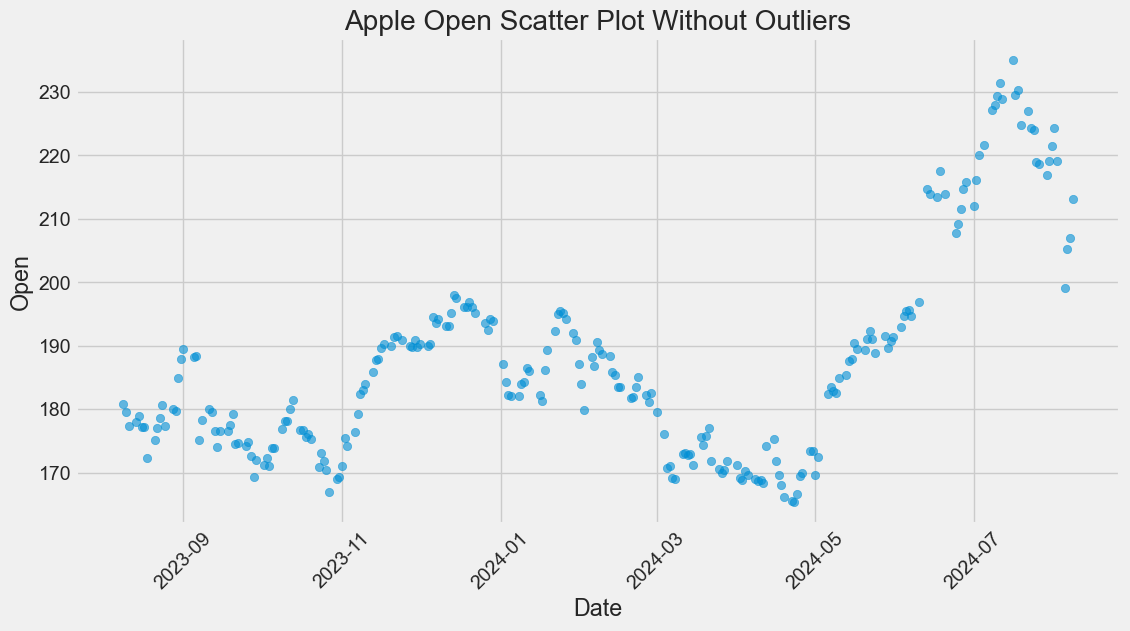

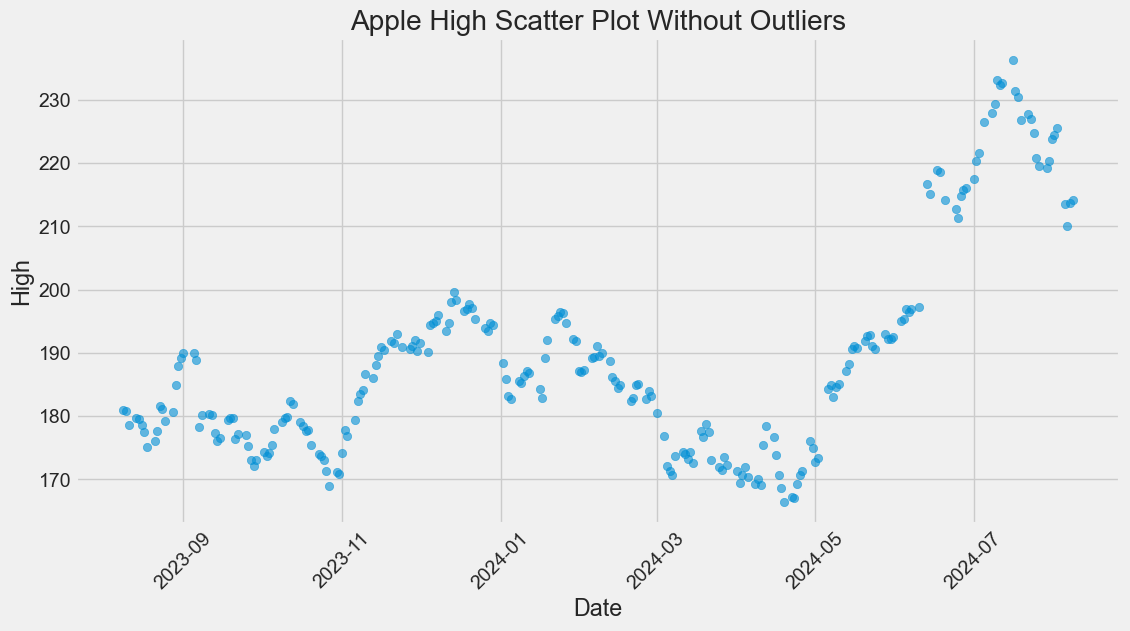

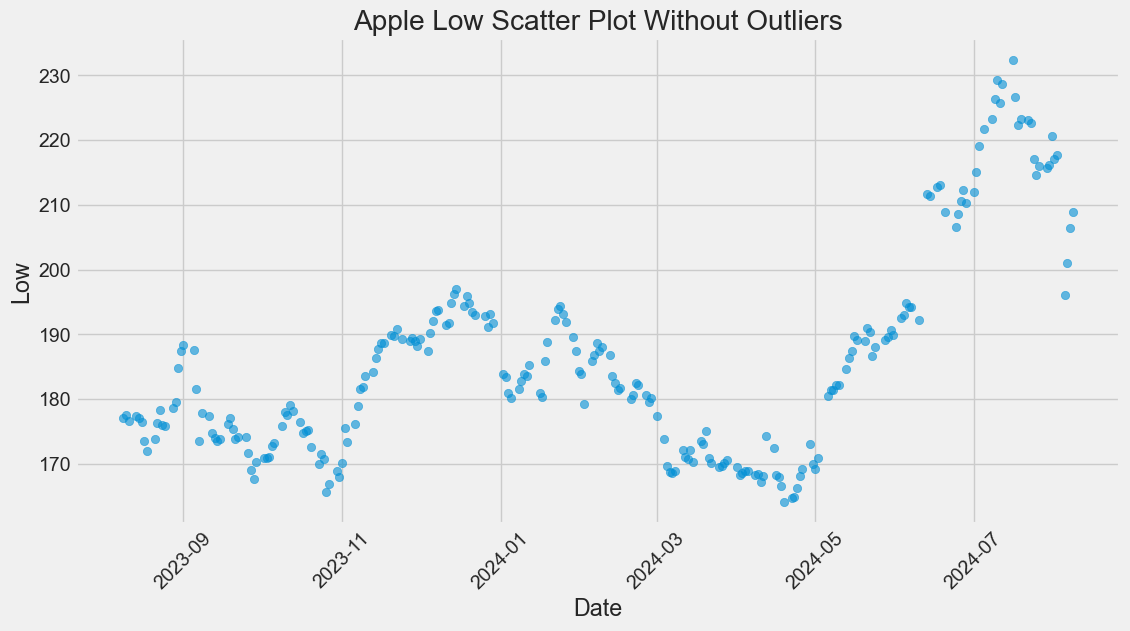

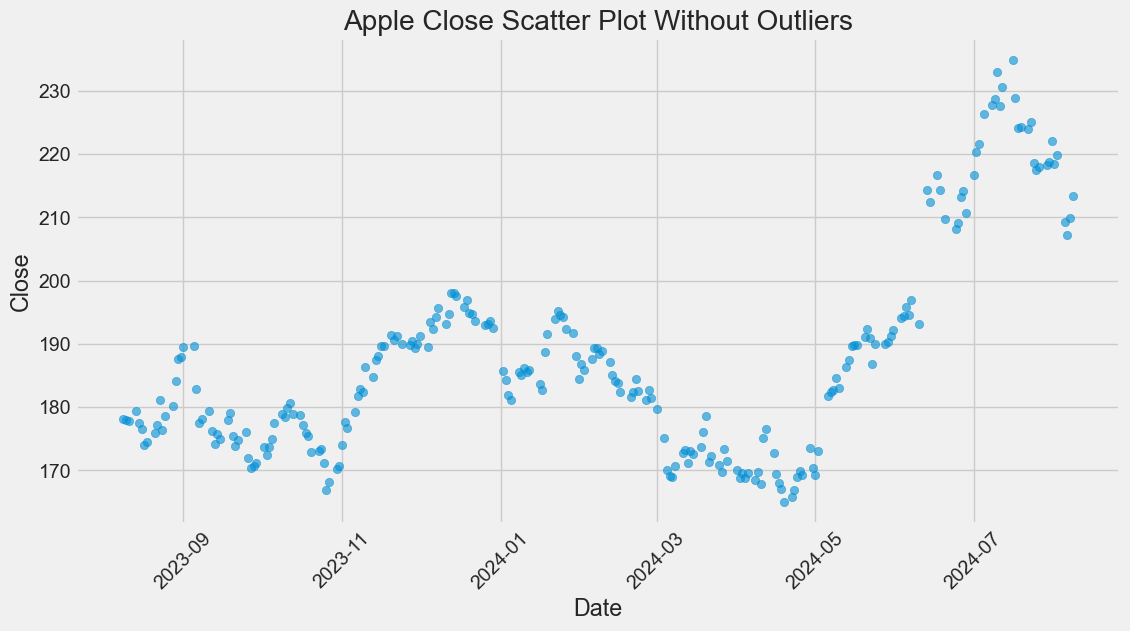

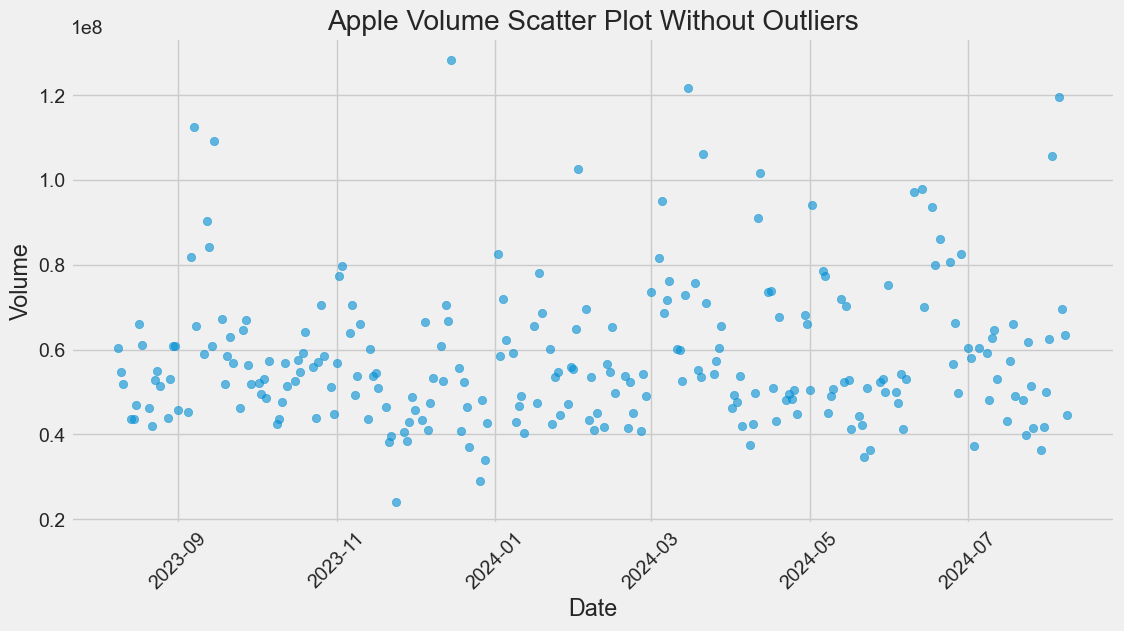

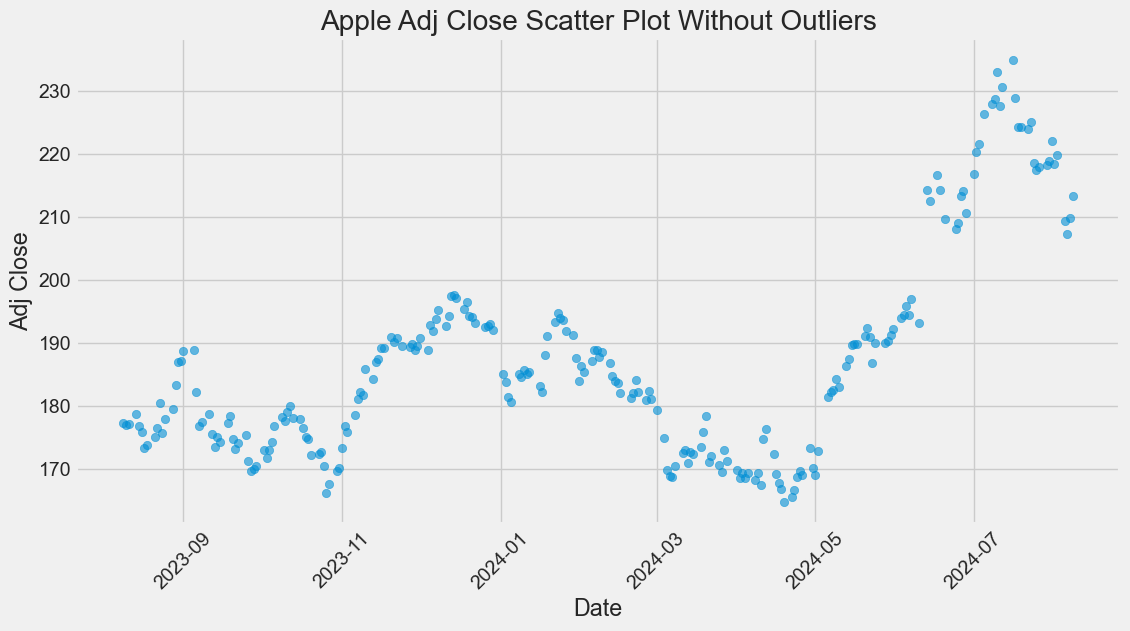

In [13]:
data = company_data['AAPL']
columns_to_keep = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
data = data[columns_to_keep]

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

#handle outliers with a method
def remove_outliers(df):
    z_scores = stats.zscore(df.select_dtypes(include=[np.number]))
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    return df[filtered_entries]

#use the method for the company
data_cleaned=remove_outliers(data)

numerical_columns = data_cleaned.select_dtypes(include=[np.number]).columns

#show the results
for column in numerical_columns:
    plt.figure(figsize=(12, 6))
    plt.scatter(data_cleaned.index, data_cleaned[column], alpha=0.6)
    plt.title(f'Apple {column} Scatter Plot Without Outliers')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.xticks(rotation=45)
    plt.show()
#print(data_cleaned.tail(10))

In [14]:
# Display the first few rows of the dataset to understand its structure
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2023-08-09,180.869995,180.929993,177.009995,178.190002,177.248672,60378500,APPLE
2023-08-10,179.479996,180.750000,177.600006,177.970001,177.029846,54686900,APPLE
2023-08-11,177.320007,178.619995,176.550003,177.789993,177.089615,51988100,APPLE
2023-08-14,177.970001,179.690002,177.309998,179.460007,178.753036,43675600,APPLE
2023-08-15,178.880005,179.479996,177.050003,177.449997,176.750946,43622600,APPLE


In [15]:
# Display the last few rows of the dataset to understand its structure
print("Last 5 rows of the dataset:")
df.tail()

Last 5 rows of the dataset:


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2024-08-02,166.750000,168.770004,160.550003,167.899994,167.899994,141448400,AMAZON
2024-08-05,154.210007,162.960007,151.610001,161.020004,161.020004,83149400,AMAZON
2024-08-06,161.710007,165.080002,158.539993,161.929993,161.929993,59950800,AMAZON
2024-08-07,166.550003,167.580002,161.429993,162.770004,162.770004,48408200,AMAZON
2024-08-08,165.169998,166.690002,162.550003,165.800003,165.800003,44518900,AMAZON


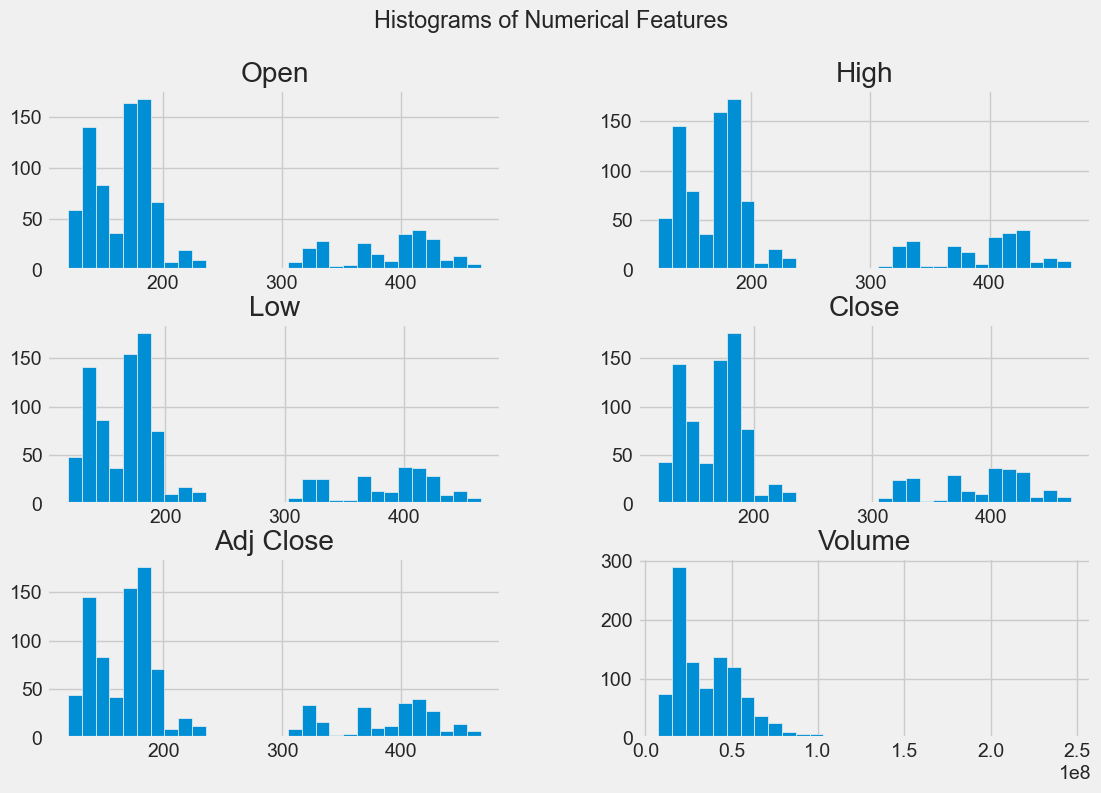

In [16]:
# Visualize the distribution of numerical features
numerical_features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
df[numerical_features].hist(bins=30, figsize=(12, 8))
plt.suptitle('Histograms of Numerical Features')
plt.show()

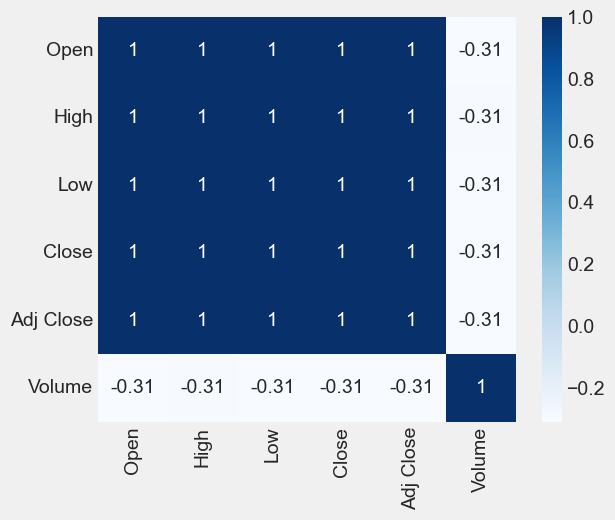

In [17]:
# A higher (darker) value represents higher correlation between the variables
# A lower (lighter) value represents lower correlation between the variables
plt.figure(figsize=(6,5))
df_disp = df.drop('company_name', axis=1)
sns.heatmap(df_disp.corr(), cmap='Blues', annot=True);
# ??????

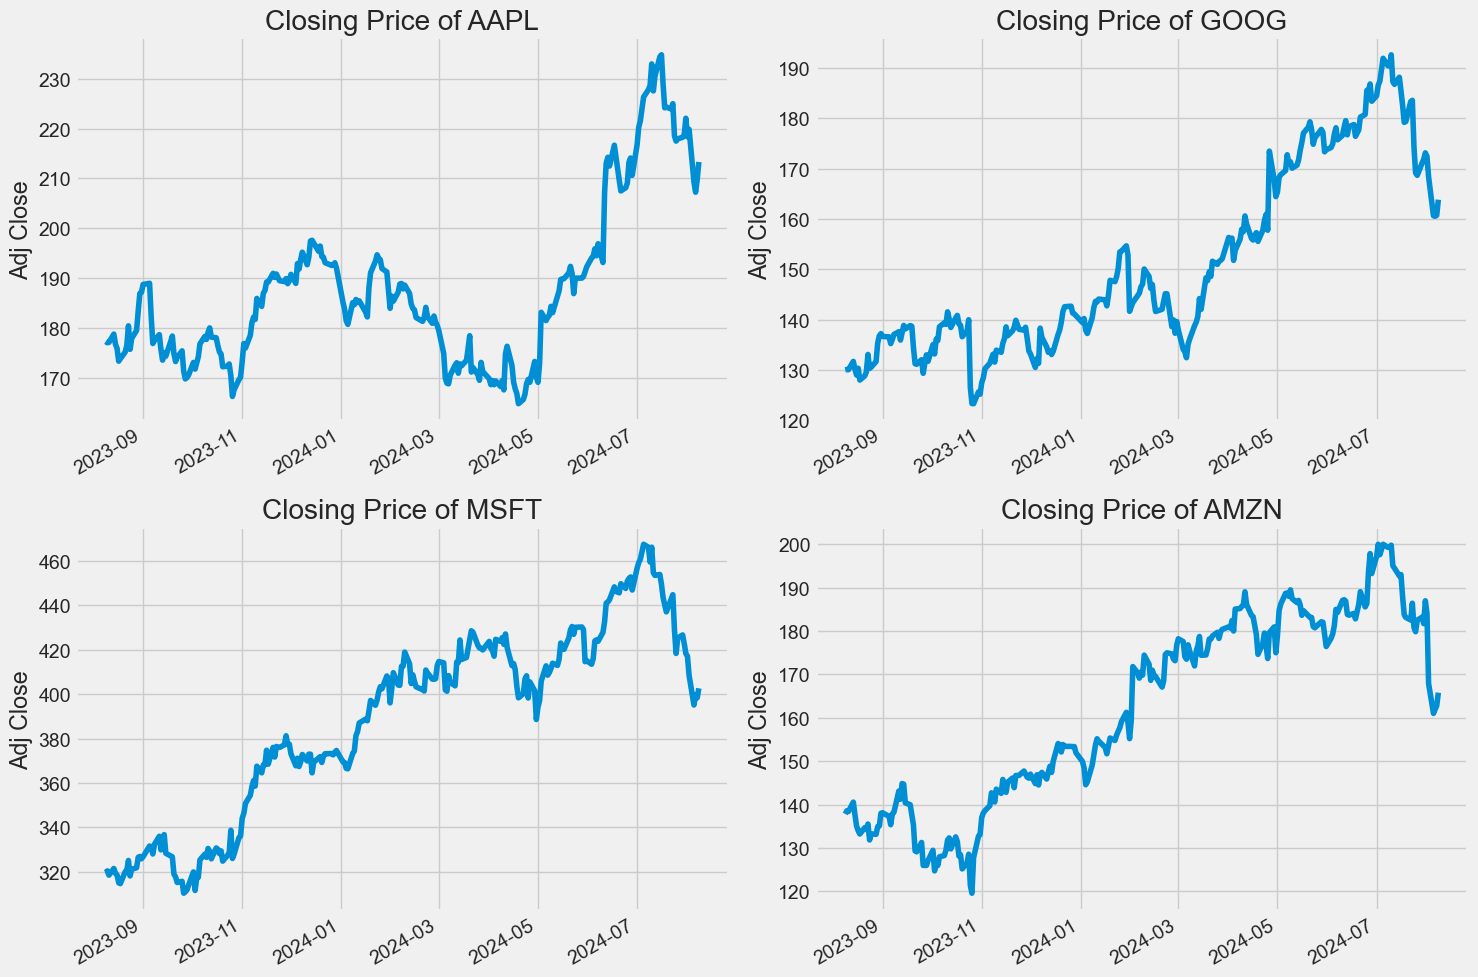

In [18]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

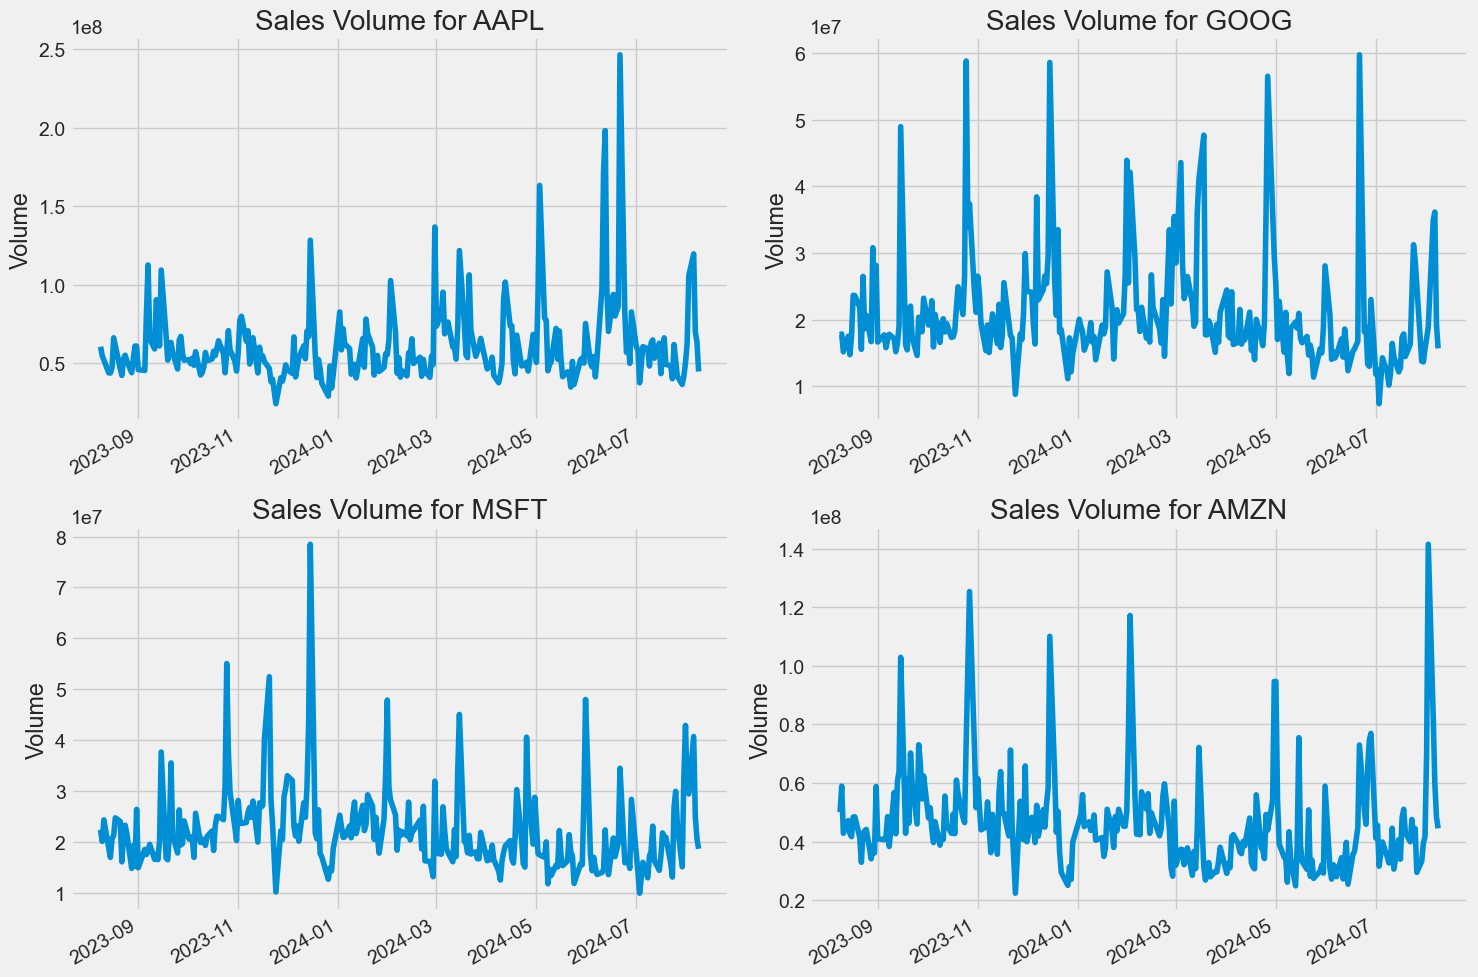

In [19]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {tech_list[i - 1]}")
    
plt.tight_layout()

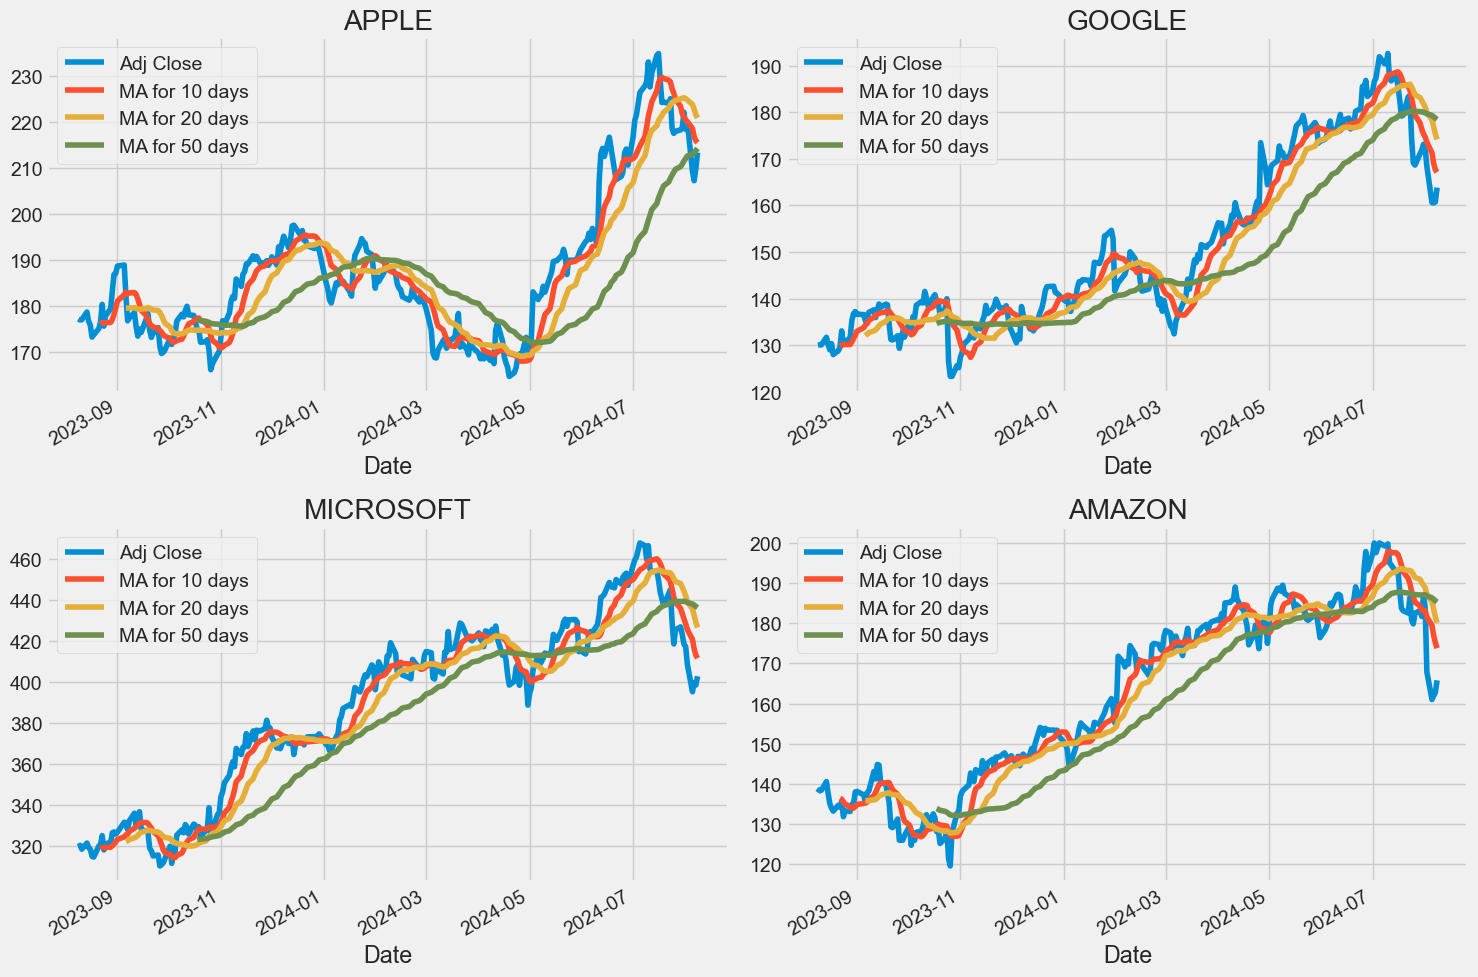

In [20]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()
        

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

company_data['AAPL'][['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

company_data['GOOG'][['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')

company_data['MSFT'][['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')

company_data['AMZN'][['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')

fig.tight_layout()
#best value to measure is 10-20 days: captures trends w/out noise

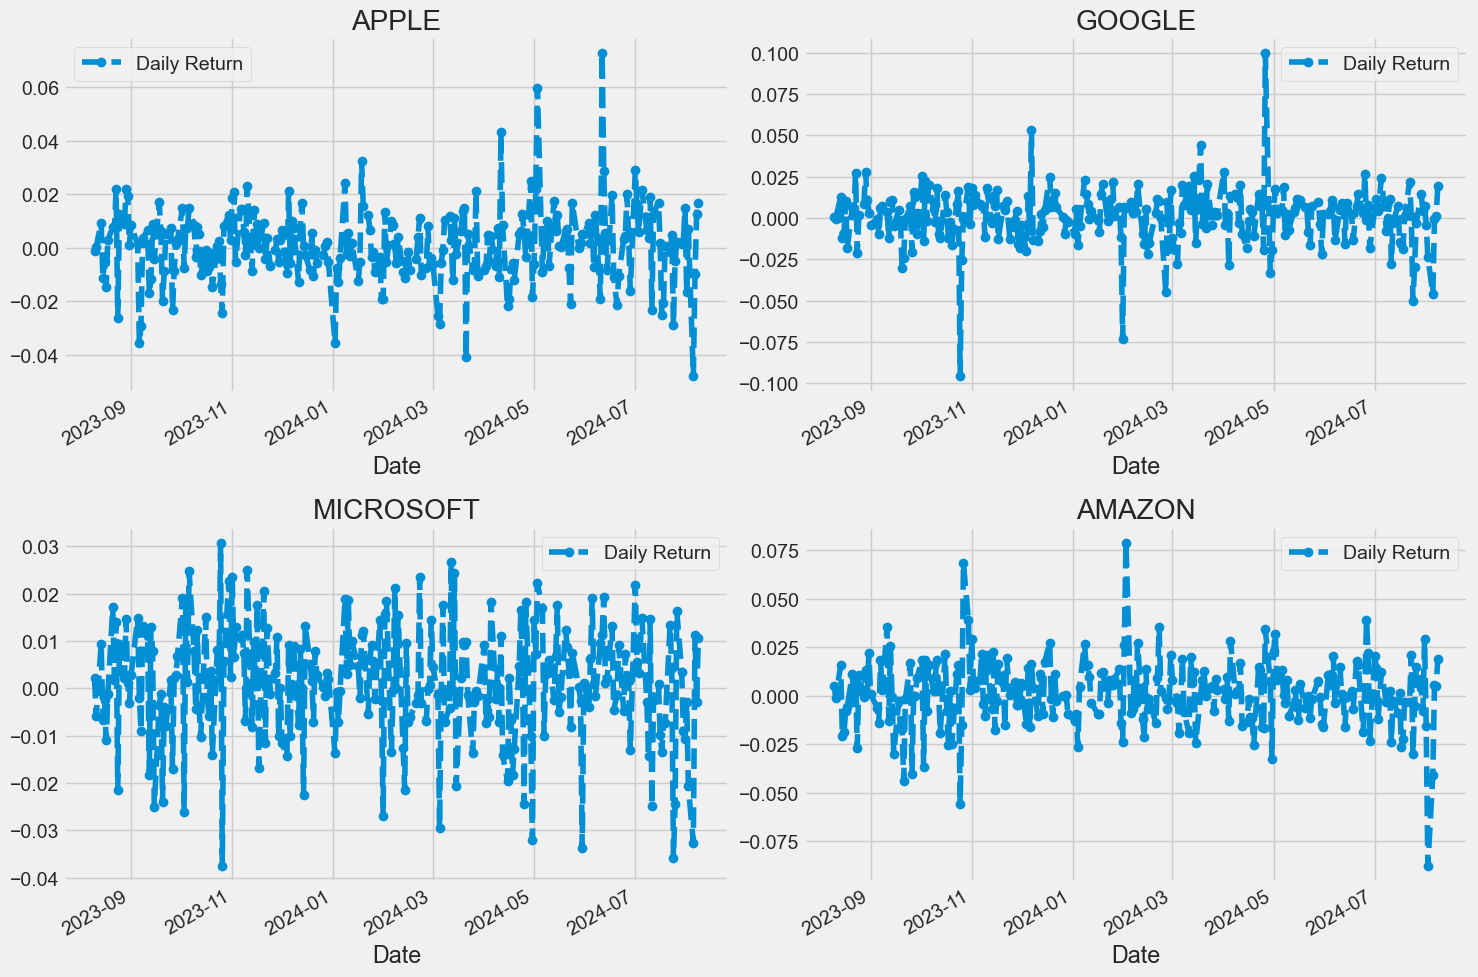

In [21]:
# We'll use pct_change to find the percent change for each day
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

company_data['AAPL']['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')

company_data['GOOG']['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE')

company_data['MSFT']['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')

company_data['AMZN']['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON')

fig.tight_layout()

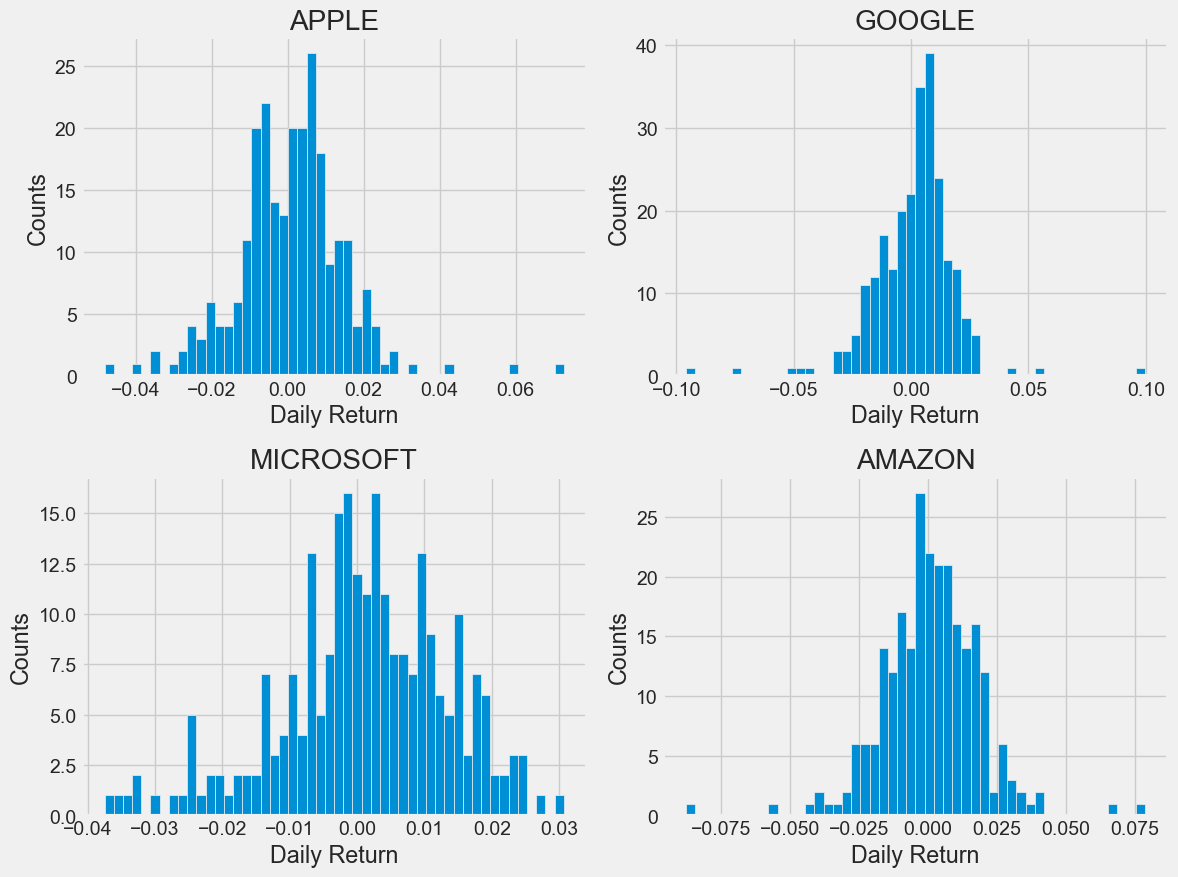

In [22]:
plt.figure(figsize=(12, 9))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Return'].hist(bins=50)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{company_name[i - 1]}')
    
plt.tight_layout()

In [23]:
# Grab all the closing prices for the tech stock list into one DataFrame
closing_df = pdr.get_data_yahoo(tech_list, start=start, end=end)['Adj Close']

# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets.head()

[*********************100%%**********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOG,MSFT
Date,,,,
2023-08-09,NaN,NaN,NaN,NaN
2023-08-10,-0.001235,0.005150,0.000461,0.002172
2023-08-11,0.000338,-0.001083,-0.000307,-0.005946
2023-08-14,0.009393,0.015606,0.012753,0.009439
2023-08-15,-0.011200,-0.020630,-0.011833,-0.006727


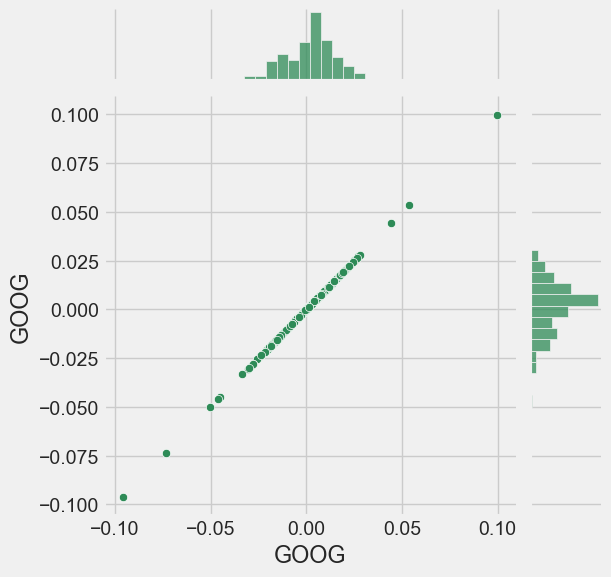

In [24]:
# Comparing Google to itself should show a perfectly linear relationship
sns.jointplot(x='GOOG', y='GOOG', data=tech_rets, kind='scatter', color='seagreen')

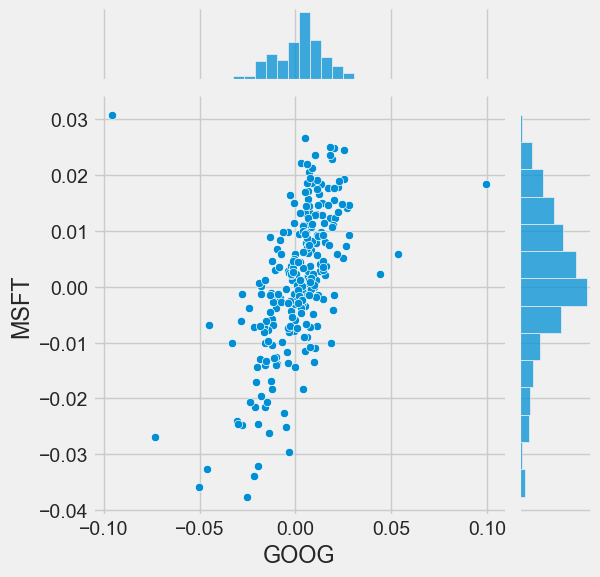

In [25]:
# We'll use joinplot to compare the daily returns of Google and Microsoft
sns.jointplot(x='GOOG', y='MSFT', data=tech_rets, kind='scatter')

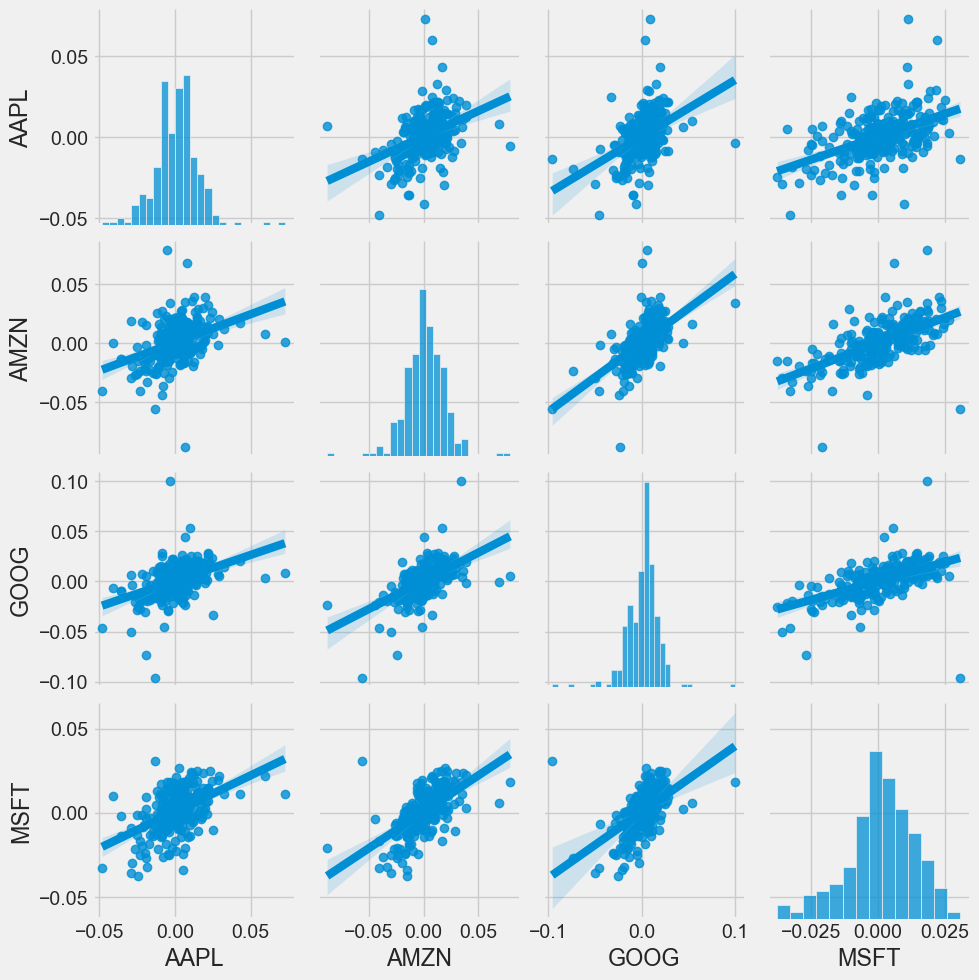

In [26]:
# We can simply call pairplot on our DataFrame for an automatic visual analysis 
# of all the comparisons

sns.pairplot(tech_rets, kind='reg')

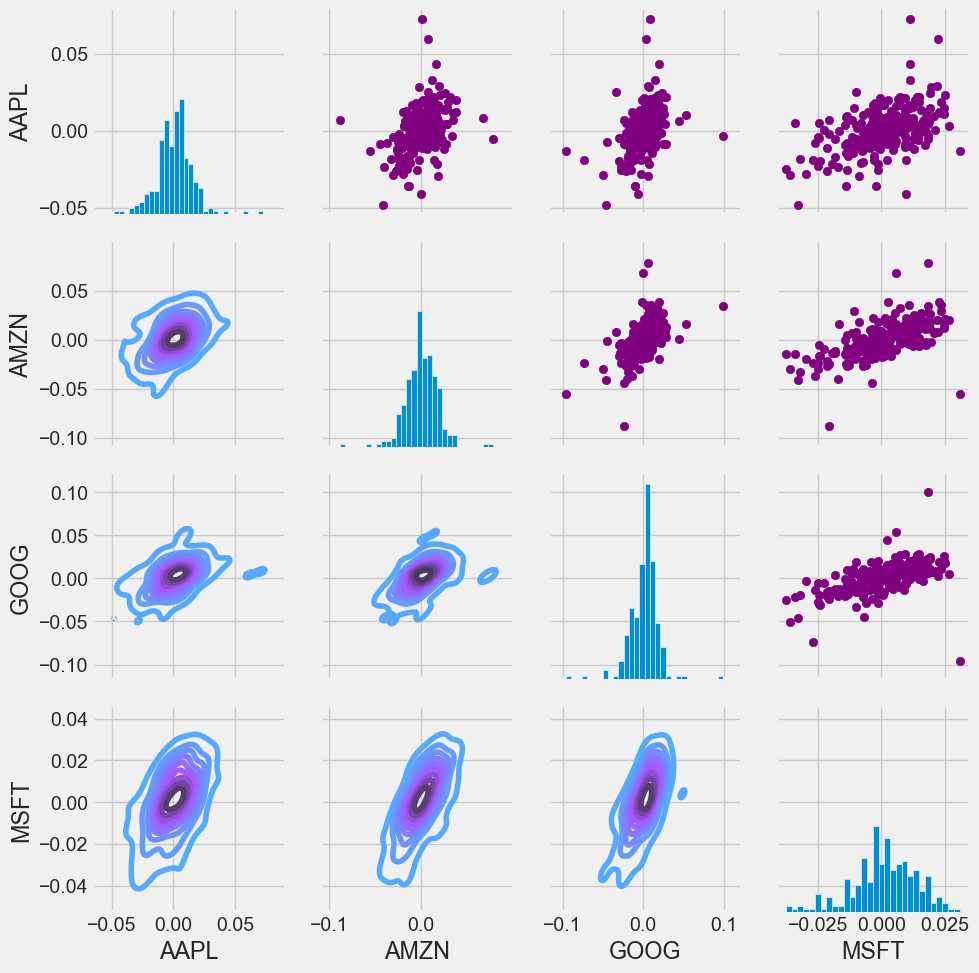

In [27]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
return_fig = sns.PairGrid(tech_rets.dropna())

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) 
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

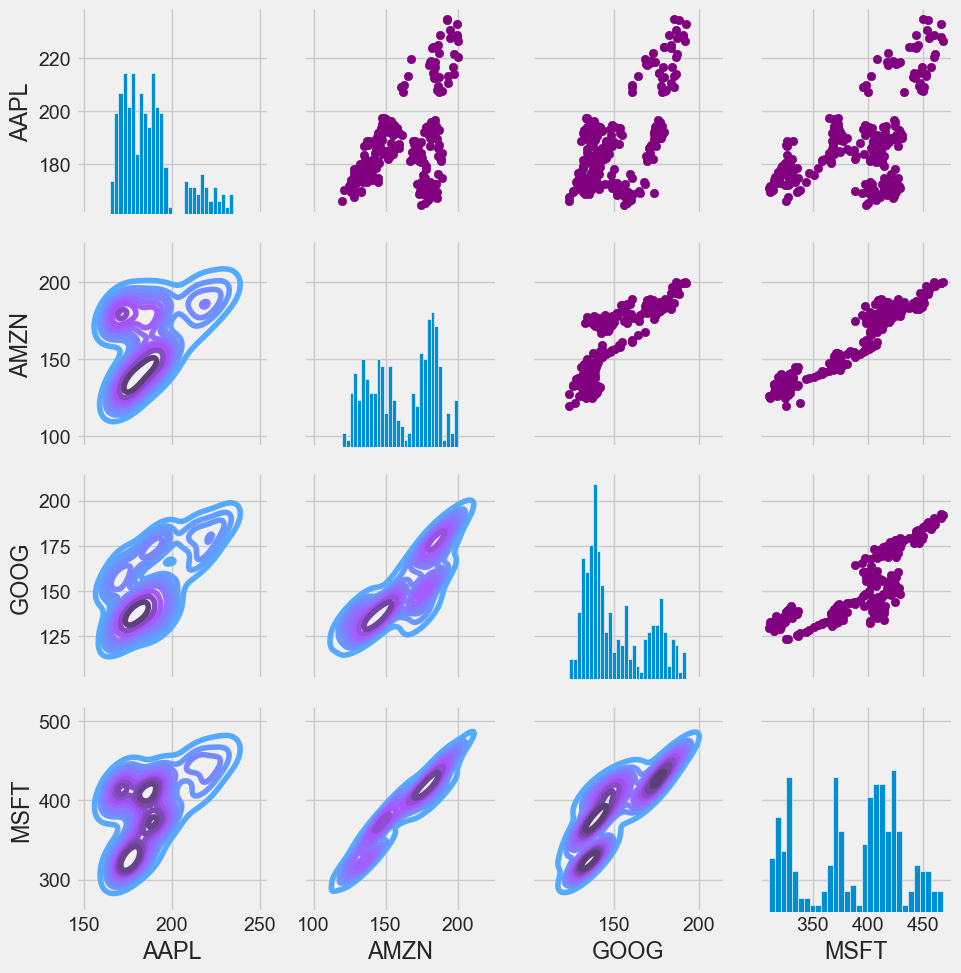

In [28]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
returns_fig = sns.PairGrid(closing_df)

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter,color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist,bins=30)

Text(0.5, 1.0, 'Correlation of stock closing price')

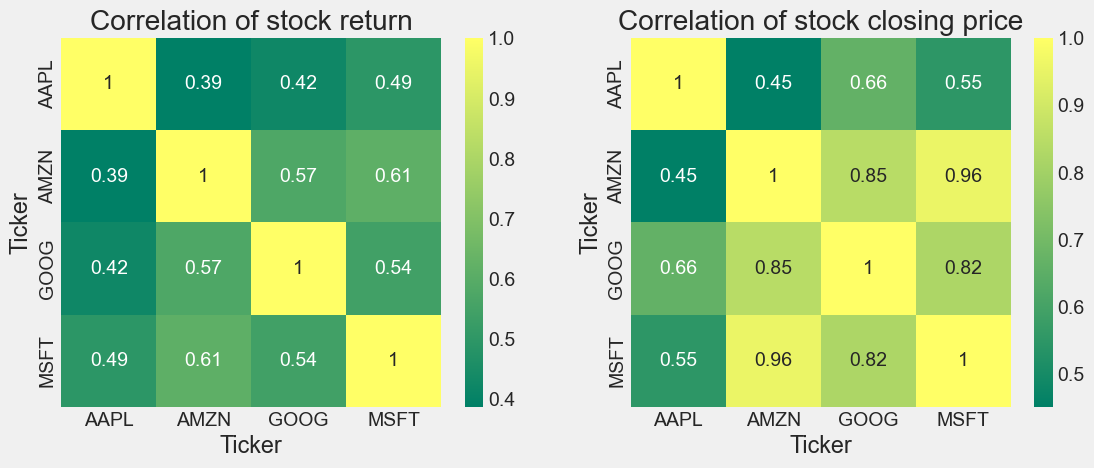

In [29]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')